![title](auxiliary/header_image.PNG)

# OST OST Tutorial I Part 2
## Pre-processing your first Sentinel-1 SLC imagery with OST


--------
This notebook is an analogy of the the GRD part to show how to create ARD data from Sentinel-1 SLC Scenes.

--------

### 1\* - Import the OST *Sentinel1_Scene* class and 2* - Create a folder for our outputs

By executing this cell, a new folder will be created and the path will be written to the *processing_dir* variable

In [1]:
# these imports we need to handle the folders, independent of the OS
import os
from os.path import join

# this is the s1Scene class, that basically handles all the workflow from beginning to the end
from ost import Sentinel1Scene

# Check if you have SNAP GPT, kinda important
from ost.helpers.utils import gpt_path
print(gpt_path())

# get home folder
home = os.getenv('HOME')
# create a processing directory
output_dir = join(home, 'Tutorial_1b')
os.makedirs(output_dir, exist_ok=True)

/home/jovyan/.ost/gpt


### 3* - Choose scene ID and display some metadata

In order to initialize an instance of the *Sentinel1_Scene* class, all we need is a valid scene id of a Sentinel-1 product. 
We select an SLC scene in this scenario.

In [2]:
# create a S1Scene class instance based on the scene identifier of the first ever Dual-Pol Sentinel-1 IW product

scene_id = 'S1B_IW_SLC__1SDV_20191004T051820_20191004T051848_018321_022835_FA70'
# create an S1Scene instance
s1 = Sentinel1Scene(scene_id)

# print summarising infos about the scene
s1.info()

 -------------------------------------------------
 Scene Information:
 Scene Identifier:        S1B_IW_SLC__1SDV_20191004T051820_20191004T051848_018321_022835_FA70
 Satellite:               Sentinel-1B
 Acquisition Mode:        Interferometric Wide Swath
 Processing Level:        1
 Product Type:            Single-Look Complex (SLC)
 Acquisition Date:        20191004
 Start Time:              051820
 Stop Time:               051848
 Absolute Orbit:          018321
 Relative Orbit:          95
 -------------------------------------------------


{'Scene_Identifier': 'S1B_IW_SLC__1SDV_20191004T051820_20191004T051848_018321_022835_FA70',
 'Satellite': 'Sentinel-1B',
 'Acquisition_Mode': 'Interferometric Wide Swath',
 'Processing_Level': '1',
 'Product_Type': 'Single-Look Complex (SLC)',
 'Acquisition_Date': '20191004',
 'Start_Time': '051820',
 'Stop_Time': '051848',
 'Absolute_Orbit': '018321',
 'Relative_Orbit': '95'}

### 4* b) - Download the/a scene direcly

The first step is to download the selected scene. In our case we chose the first regular Sentinel-1 IW product acquired in the dual-polarisation VV/VH acquired the 3rd of October 2014. 
OST provides download from 3 different mirrors, ESA's scihub, CNES PEPS and Alaska Satellite Facility (NASA Earthdata). Since ESA's official scihub became a rolling archive, and so is PEPS, best is to download from the fantastic **Alaska Satellite Facility** mirror (selection 2), which holds the full Sentinel-1 archive online. 

**Note:** At the end the downloaded file will be checked. This assures that the download went fine and we can use it for processing. In addiiton, OST will also magically remember that this file has been successfully downloaded.

In [3]:
s1.download(output_dir)

Type 1, 2 or 3:  2
Username: suprd
Password: ·········


### 5* - Create an SLC ARD product

Analysis Ready Data is interpreted differently by different persons. 

The default ARD type is *'OST'*. For SLC products you can select othe same ARD (backscatter) types, or it allows customising single ARD parameters.

See in the cell below the different definitions possible, and also note how the resolution and the resampling of the image during terrain correction is changed at the bottom. In this way, all parameters can be customised. 

In [5]:
print(' Our ARD parameters dictionary contains folowing keys.')
print(s1.ard_parameters.keys())
print('')
print(' Dictionary of our standard OST ARD parameters for the scene processing:')
print(s1.ard_parameters)
print('')


# we change ARD type
# possible coices are:
# 'OST', 'OST_flat', 'CEOS', 'EarthEngine'
s1.set_ard_parameters('EarthEngine')
print(' Dictionary of OST ARD parameters for the scene processing:')
print(s1.ard_parameters)
print('')

# we customize the resolution and image resampling
s1.ard_parameters['resolution'] = 20
s1.ard_parameters['resampling'] = 'BILINEAR_INTERPOLATION'
print(s1.ard_parameters)

 Our ARD parameters dictionary contains folowing keys.
dict_keys(['type', 'resolution', 'border_noise', 'product_type', 'speckle_filter', 'ls_mask_create', 'to_db', 'dem', 'resampling'])

 Dictionary of our standard OST ARD parameters for the scene processing:
{'type': 'OST', 'resolution': 20, 'border_noise': True, 'product_type': 'GTCgamma', 'speckle_filter': False, 'ls_mask_create': False, 'to_db': False, 'dem': 'SRTM 1Sec HGT', 'resampling': 'CUBIC_CONVOLUTION'}

 Dictionary of OST ARD parameters for the scene processing:
{'type': 'EarthEngine', 'resolution': 10, 'border_noise': True, 'product_type': 'GTCsigma', 'speckle_filter': False, 'ls_mask_create': False, 'to_db': True, 'dem': 'SRTM 1Sec HGT', 'resampling': 'BISINC_5_POINT_INTERPOLATION'}

{'type': 'EarthEngine', 'resolution': 20, 'border_noise': True, 'product_type': 'GTCsigma', 'speckle_filter': False, 'ls_mask_create': False, 'to_db': True, 'dem': 'SRTM 1Sec HGT', 'resampling': 'BILINEAR_INTERPOLATION'}


Our *Sentinel1_Scene* class comes with the build-in method *create_ard* to produce a standardised ARD product based on the ARD dictionary above. 

To run the command we just have to provide: 
- the path to the downloaded file. We can use the *get_path* method in conjunction with the download directory provided
- a directory where the outputfiles will be written to
- a filename prefix (the output format will be the standard SNAP Dimap format, consisting of the dim-file and the data directory)
- and a directory for storing temporary files (can not be the same as the output folder)
- we can provide a subset to process just the relevant bursts(if not given, whole product will be processed)

In [7]:
from tempfile import TemporaryDirectory
from ost.helpers import vector

# The scene is around Venice sou let's go with couple of km around it, or let's go with 100 km why not
lon, lat  = 12.33151, 45.46770
subset = vector.latlon_to_wkt(lat, lon, buffer_meter=100000, envelope=True)

# Setup logging so we can see the progress
import logging
from ost.log import set_log_level
set_log_level(logging.DEBUG)

with TemporaryDirectory() as temp:
    print(s1.get_path(output_dir))
    s1.create_ard(filelist = s1.get_path(output_dir),
                  out_dir = output_dir,   
                  out_prefix = s1.scene_id,   
                  temp_dir = temp, # needs to be different from our output dir
                  subset=subset
                 ) 

print(' The path to our newly created ARD product can be obtained the following way:')
s1.ard_dimap

/home/jovyan/Tutorial_1b/SAR/SLC/2019/10/04/S1B_IW_SLC__1SDV_20191004T051820_20191004T051848_018321_022835_FA70.zip


2020-02-19 15:52:55,156 DEBUG ost.s1.burst_to_ard INFO: Importing Burst 1 from Swath IW1 from scene S1B_IW_SLC__1SDV_20191004T051820_20191004T051848_018321_022835_FA70.zip
2020-02-19 15:52:55,156 DEBUG ost.s1.burst_to_ard INFO: Importing Burst 2 from Swath IW1 from scene S1B_IW_SLC__1SDV_20191004T051820_20191004T051848_018321_022835_FA70.zip
2020-02-19 15:52:55,156 DEBUG ost.s1.burst_to_ard INFO: Importing Burst 3 from Swath IW1 from scene S1B_IW_SLC__1SDV_20191004T051820_20191004T051848_018321_022835_FA70.zip
2020-02-19 15:52:55,156 DEBUG ost.s1.burst_to_ard INFO: Importing Burst 4 from Swath IW1 from scene S1B_IW_SLC__1SDV_20191004T051820_20191004T051848_018321_022835_FA70.zip
2020-02-19 15:52:55,156 DEBUG ost.s1.burst_to_ard INFO: Importing Burst 5 from Swath IW1 from scene S1B_IW_SLC__1SDV_20191004T051820_20191004T051848_018321_022835_FA70.zip
2020-02-19 15:52:55,156 DEBUG ost.s1.burst_to_ard INFO: Importing Burst 7 from Swath IW1 from scene S1B_IW_SLC__1SDV_20191004T051820_2019100

 The path to our newly created ARD product can be obtained the following way:


['/home/jovyan/Tutorial_1b/S1B_IW_SLC__1SDV_20191004T051820_20191004T051848_018321_022835_FA70_22209_BS.dim',
 '/home/jovyan/Tutorial_1b/S1B_IW_SLC__1SDV_20191004T051820_20191004T051848_018321_022835_FA70_22126_BS.dim',
 '/home/jovyan/Tutorial_1b/S1B_IW_SLC__1SDV_20191004T051820_20191004T051848_018321_022835_FA70_22099_BS.dim',
 '/home/jovyan/Tutorial_1b/S1B_IW_SLC__1SDV_20191004T051820_20191004T051848_018321_022835_FA70_22154_BS.dim',
 '/home/jovyan/Tutorial_1b/S1B_IW_SLC__1SDV_20191004T051820_20191004T051848_018321_022835_FA70_22071_BS.dim',
 '/home/jovyan/Tutorial_1b/S1B_IW_SLC__1SDV_20191004T051820_20191004T051848_018321_022835_FA70_22182_BS.dim',
 '/home/jovyan/Tutorial_1b/S1B_IW_SLC__1SDV_20191004T051820_20191004T051848_018321_022835_FA70_22044_BS.dim',
 '/home/jovyan/Tutorial_1b/S1B_IW_SLC__1SDV_20191004T051820_20191004T051848_018321_022835_FA70_22016_BS.dim',
 '/home/jovyan/Tutorial_1b/S1B_IW_SLC__1SDV_20191004T051820_20191004T051848_018321_022835_FA70_22237_BS.dim',
 '/home/jo

### 6* - Create a RGB color composite and 7* - Visualise the RGB composite

Sentinel-1 scenes usually consist of two polarisation bands. In order to create a 3 channel RGB composite a ratio between the Co- (VV or HH) and the Cross-polarised (VH or HV) band is added. The *create_rgb* method takes the *ard_dimap* file and converts it to a 3-channel GeoTiff.

We can plot the newly created RGB image with the *visualise_rgb* method. A *shrink_factor* is added, which reduces resolution in favour of memory requirements for plotting.

2020-02-19 16:06:34,417 DEBUG ost.s1.s1scene Creating RGB Geotiff for scene: S1B_IW_SLC__1SDV_20191004T051820_20191004T051848_018321_022835_FA70
2020-02-19 16:14:39,545 DEBUG ost.s1.s1scene RGB Geotiff done for scene: S1B_IW_SLC__1SDV_20191004T051820_20191004T051848_018321_022835_FA70


 The path to our newly created RGB product can be obtained the follwing way:
Populating the interactive namespace from numpy and matplotlib


/home/jovyan/git/OpenSarToolkit/ost/helpers/raster.py:302: RuntimeWarning: invalid value encountered in greater
  float_array[float_array > max_value] = max_value
/home/jovyan/git/OpenSarToolkit/ost/helpers/raster.py:303: RuntimeWarning: invalid value encountered in less
  float_array[float_array < min_value] = min_value


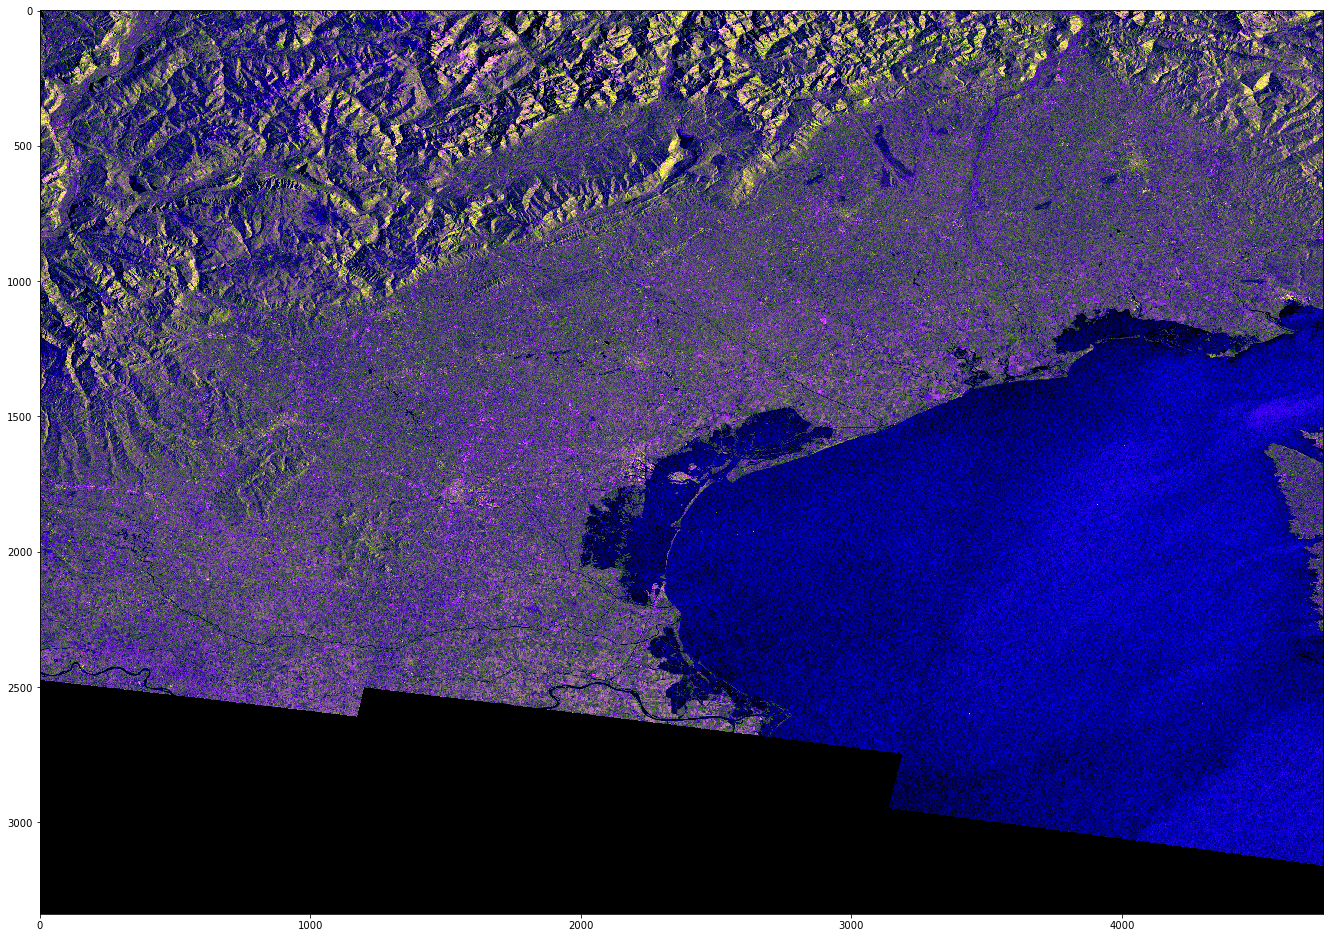

In [8]:
s1.create_rgb(outfile = join(output_dir, s1.start_date+'_'+s1.ard_parameters['product_type']+'.tif'))

print(' The path to our newly created RGB product can be obtained the follwing way:')
s1.ard_rgb

#---------------------------------------------------
# for plotting purposes we use this iPython magic
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (23, 23)
#---------------------------------------------------
s1.visualise_rgb(shrink_factor=15)

### 8* - Create thumbnail image

For some it might be interesting to create a small thumbnail image in Jpeg format. The *create_rgb_thumbnail* method allows for this. 

44K /home/jovyan/Tutorial_1b/20191004.TN.jpg


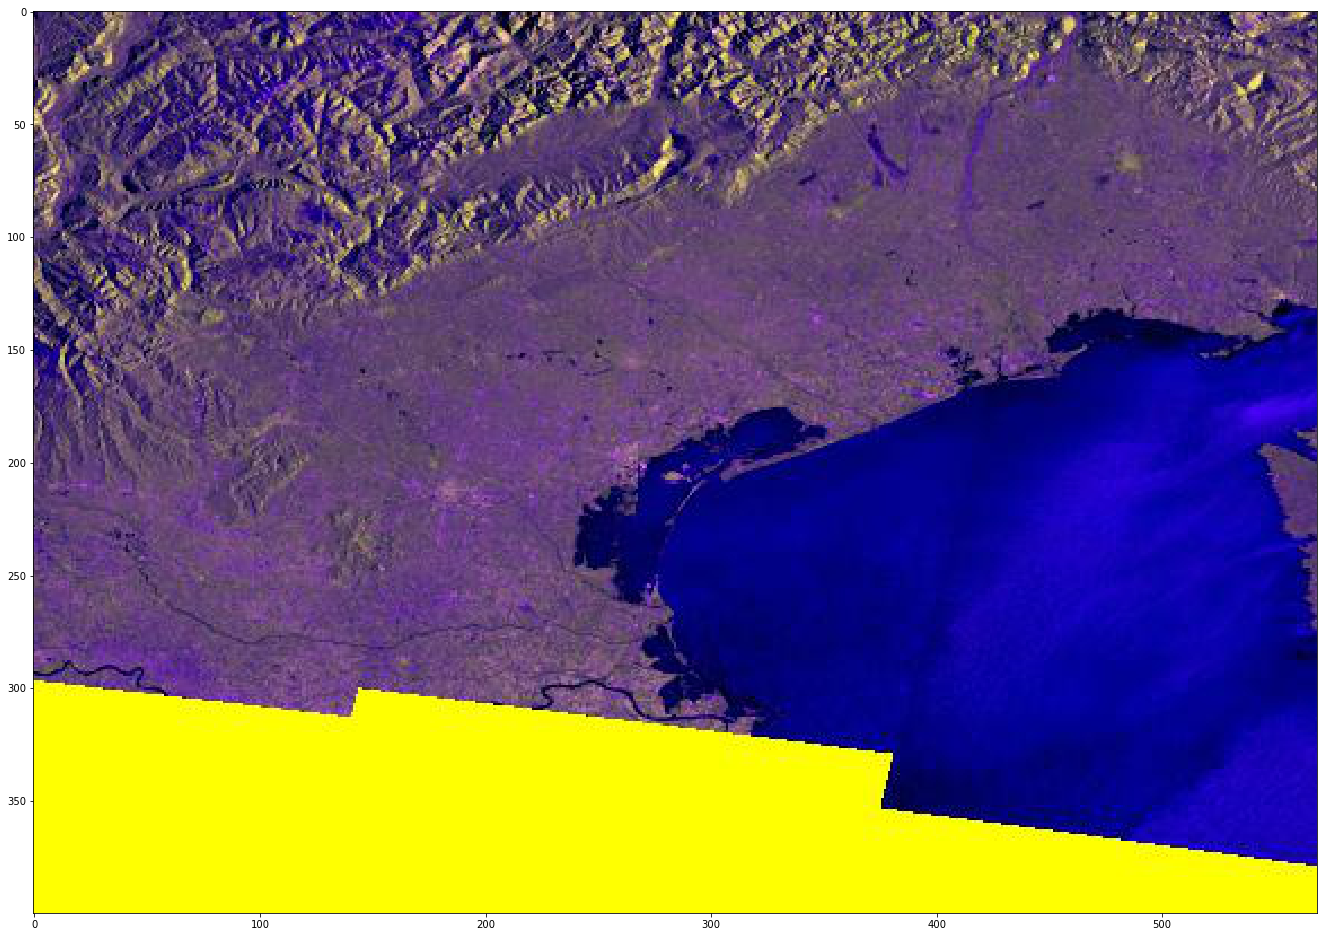

In [9]:
# define a filename for our thumbnail image
path_to_thumbnail = join(output_dir, '{}.TN.jpg'.format(s1.start_date))
# create the thumbnail image
s1.create_rgb_thumbnail(outfile = path_to_thumbnail)

import imageio
img = imageio.imread(path_to_thumbnail)
!ls -sh {path_to_thumbnail}
plt.imshow(img)

### 9* - Terrain Flattening

Let's not do this now as it takes a lot of time.